### Reading Data from InfluxDB

In [1]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS


token = os.environ.get("<your influx db token>")
org = "<your influx db org name>"
url = "<your influx db custom url>"

client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()

query = """from(bucket: "<your influx db bucket name>")
  |> range(start: -1000m)
  |> filter(fn: (r) => r._measurement == "passengers")
  |> mean()"""
tables = query_api.query(query, org=org)

results = []
for table in tables:
    for record in table.records:
        results.append(({'month': record.values.get('month'), record.get_field(): record.get_value()}))

### Forecasting with Kats Base Models

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from kats.models.sarima import SARIMAModel, SARIMAParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from kats.models.prophet import ProphetModel, ProphetParams
from kats.consts import TimeSeriesData

warnings.simplefilter(action='ignore')

air_passengers_df = pd.DataFrame(results)
air_passengers_df.sort_values('month', inplace=True)
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

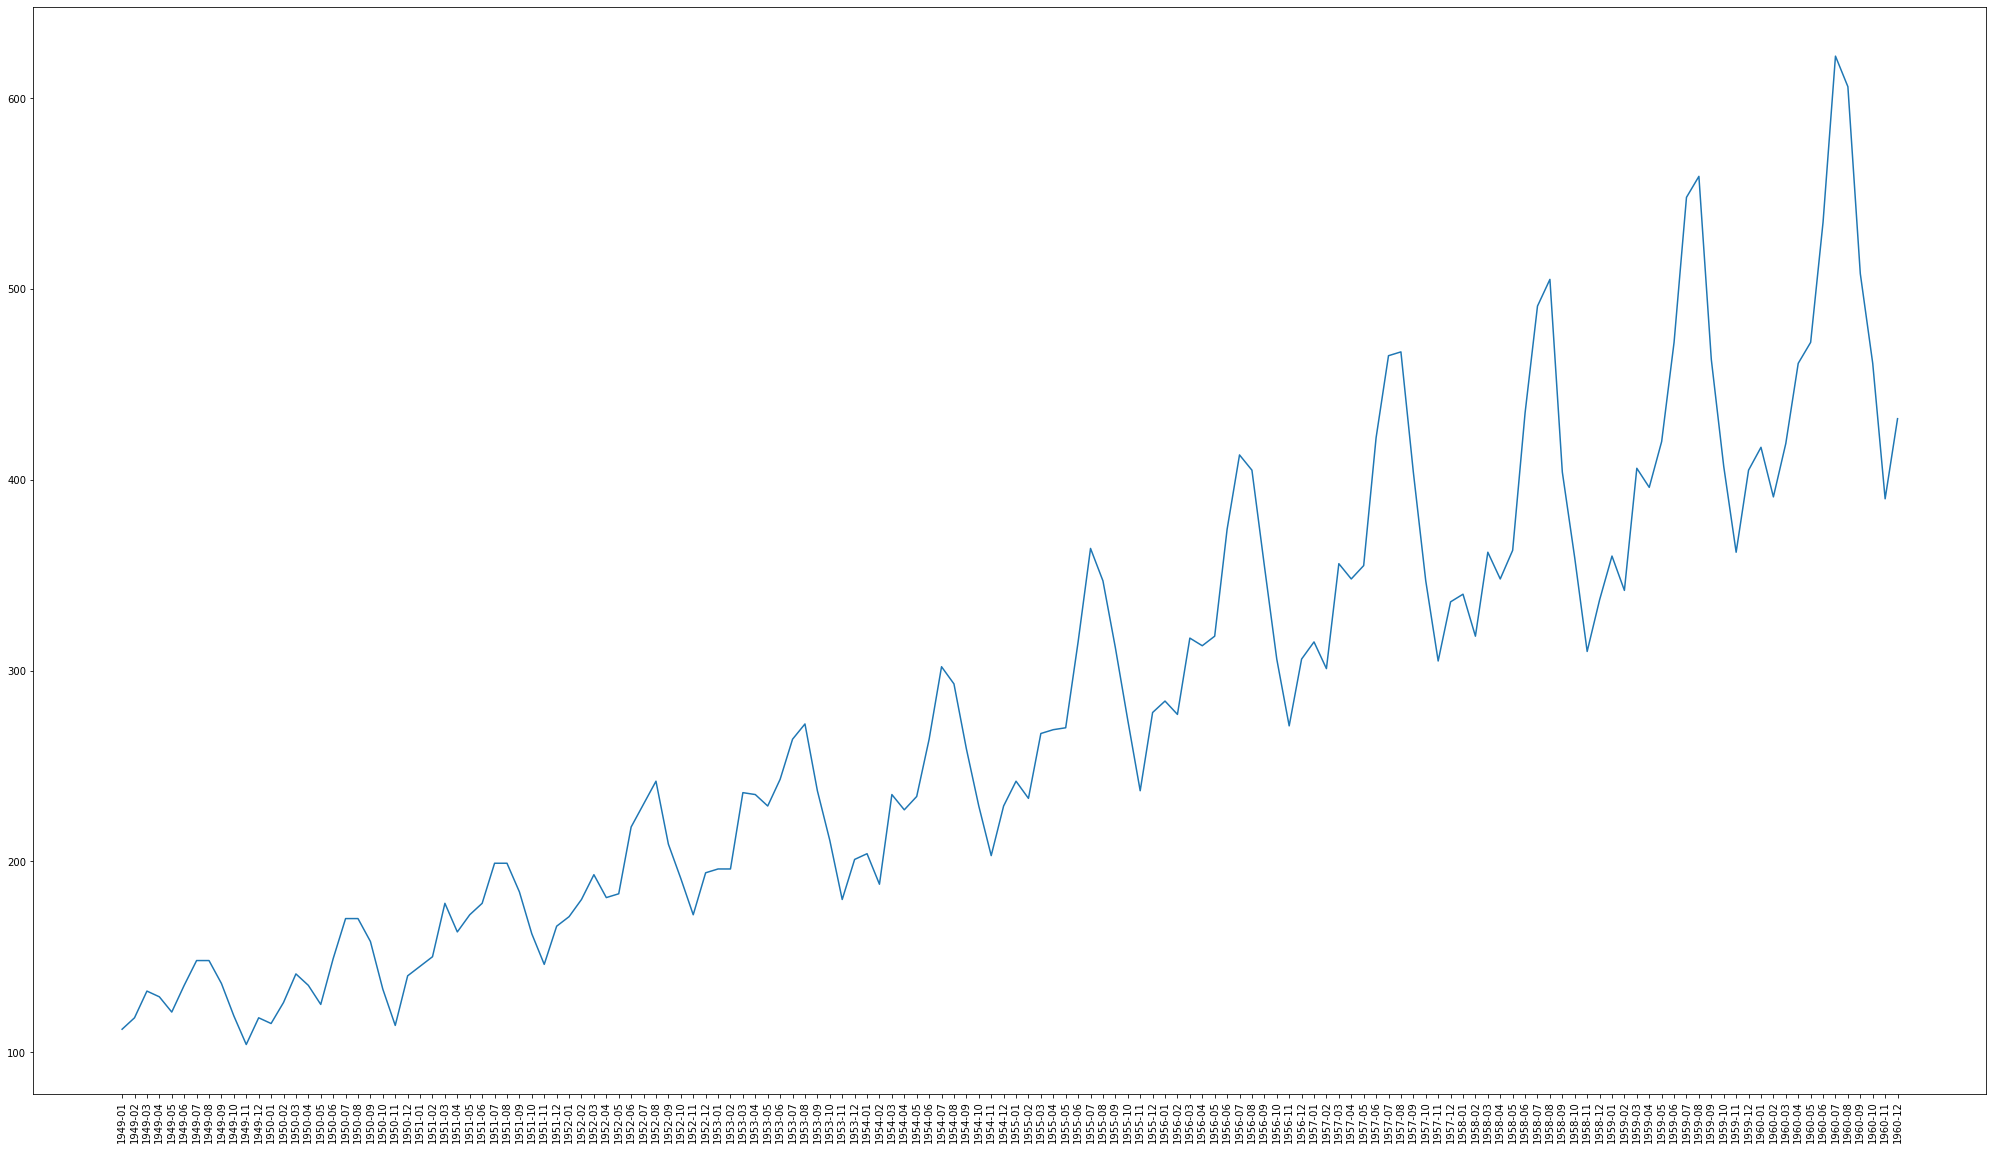

In [3]:
plt.figure(figsize=(35,20))
fig = plt.plot(air_passengers_df['time'], air_passengers_df["value"])
plt.xticks(rotation=90)
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
X = air_passengers_df["value"]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.815369
p-value: 0.991880


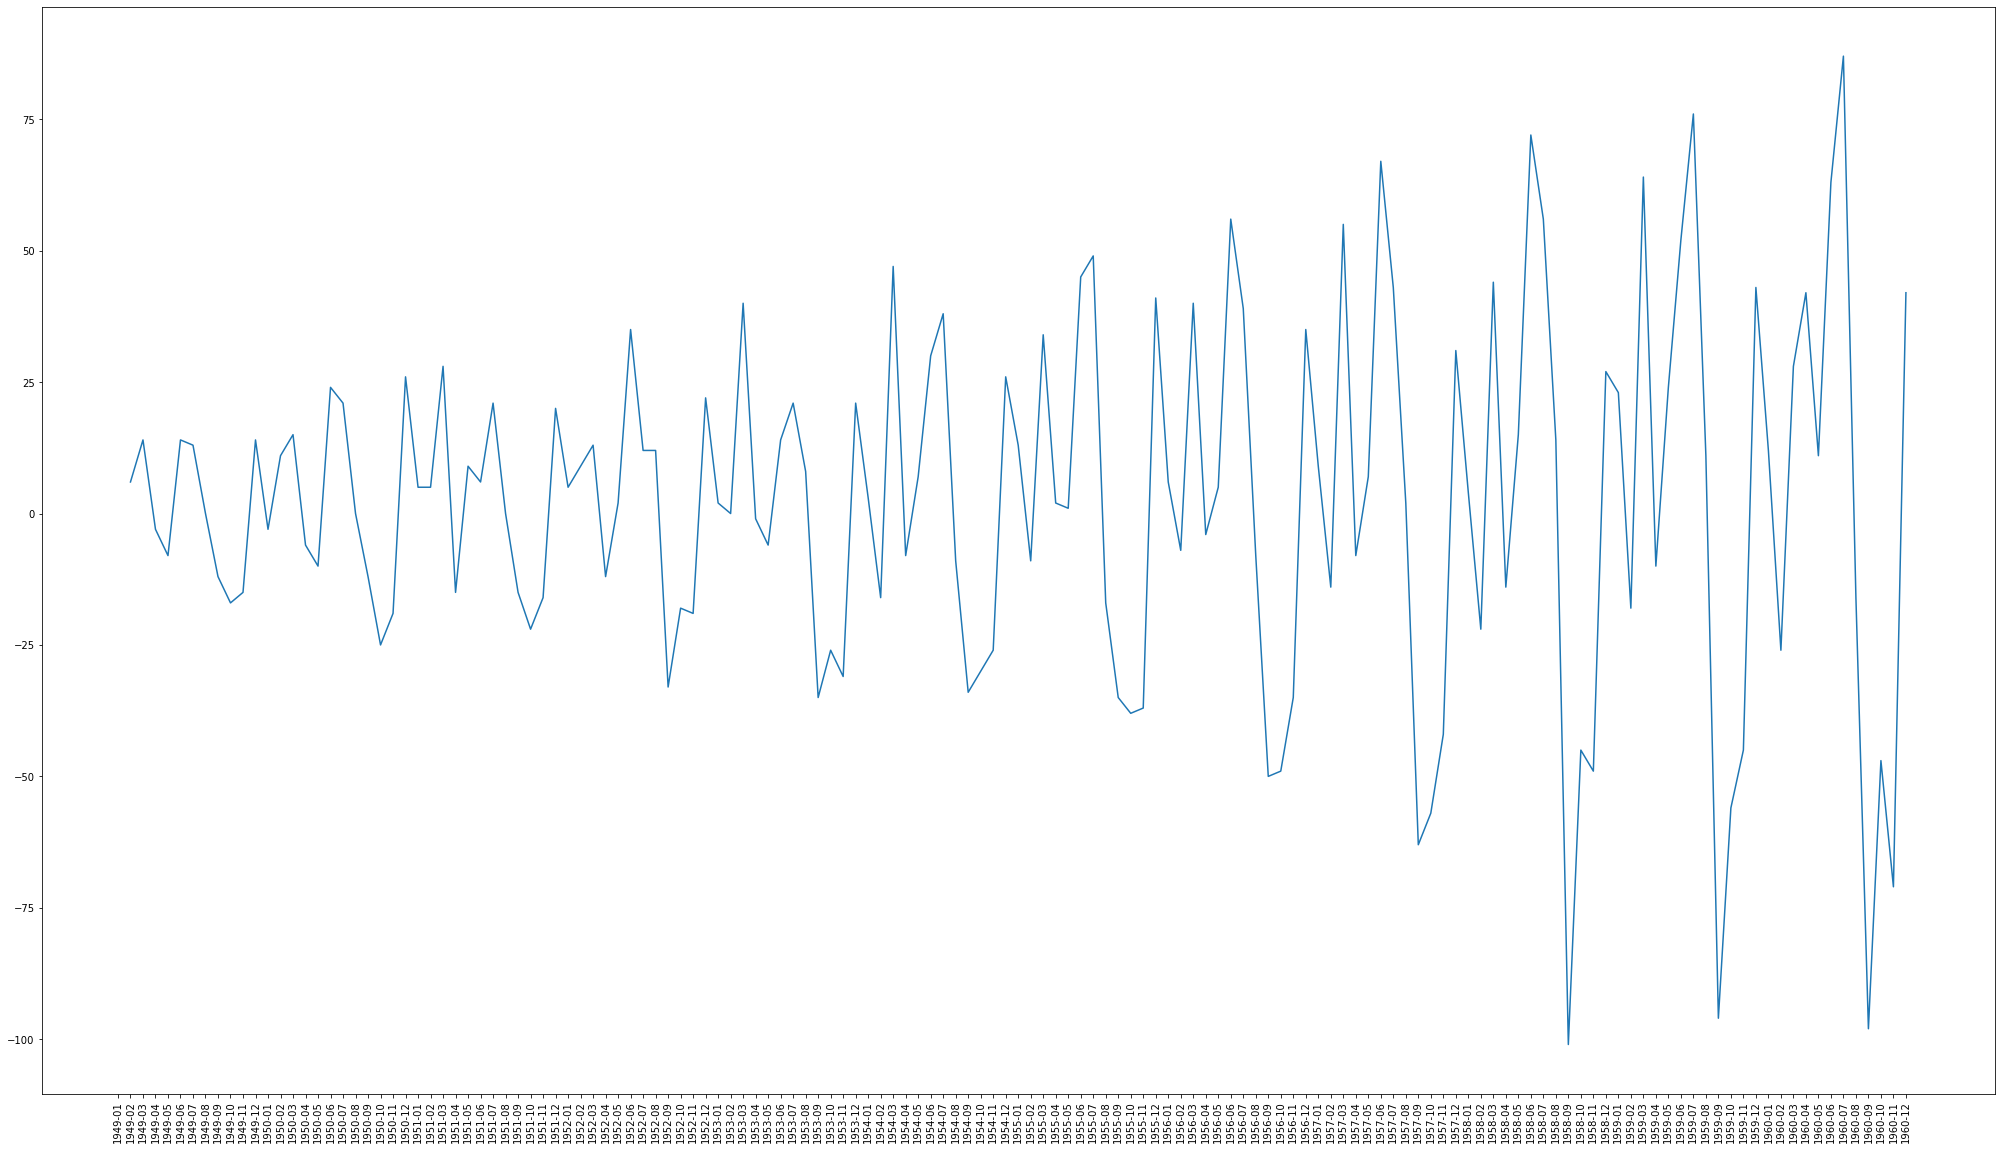

In [5]:
plt.figure(figsize=(35,20))
fig = plt.plot(air_passengers_df['time'], air_passengers_df["value"].diff())
plt.xticks(rotation=90)
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller
X = air_passengers_df["value"]
result = adfuller(X.diff()[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.829267
p-value: 0.054213


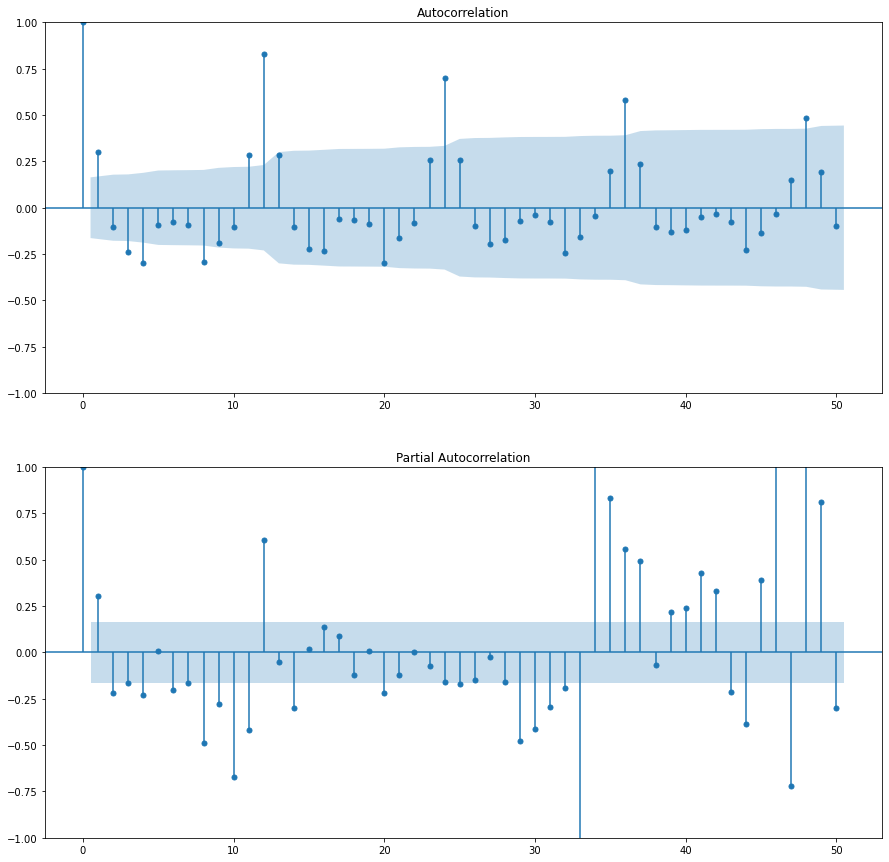

In [7]:
fig, ax = plt.subplots(2,1)
fig.set_figheight(15)
fig.set_figwidth(15)
fig = sm.graphics.tsa.plot_acf(air_passengers_df["value"].diff()[1:], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(air_passengers_df["value"].diff()[1:], lags=50, ax=ax[1])
plt.show()

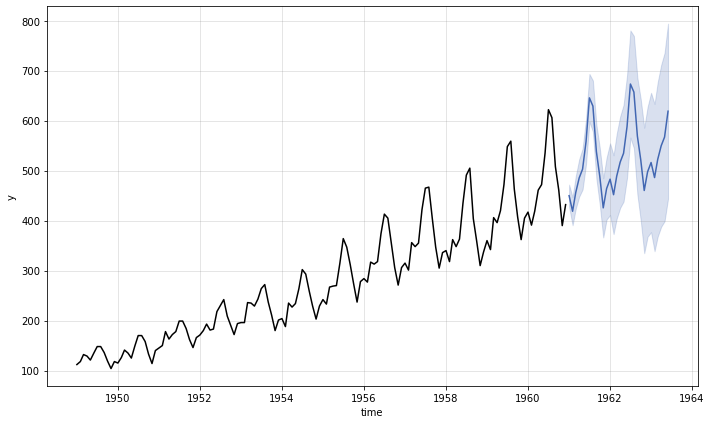

In [8]:
# declare SARIMA parameters - use acf/pacf charts and grid search
params = SARIMAParams(p = 2, d=1, q=1, seasonal_order=(1,0,1,12), trend = 'ct')

# train sarima model
m = SARIMAModel(data=air_passengers_ts, params=params)
m.fit()

#forecast for next 30 months
fcst = m.predict(steps=30, freq="MS")

# visualize predictions
m.plot()

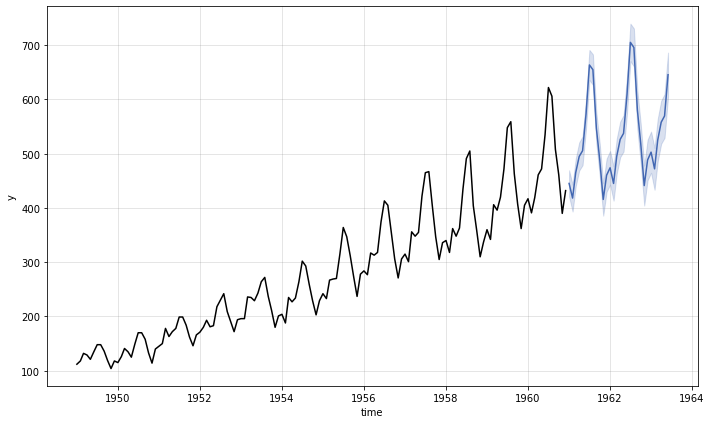

In [9]:
# declare parameters for Holt Winters model
params = HoltWintersParams(trend="add", seasonal="mul", seasonal_periods=12)

# fit a Holt Winters model
hw_model = HoltWintersModel(data=air_passengers_ts, params=params)
hw_model.fit()

# forecast for next 30 months
fcst = hw_model.predict(steps=30, alpha = 0.1)

# plot predictions
hw_model.plot()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.689   0.000676126       99.3685      0.8361      0.8361      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        503.23    0.00055319       79.9039           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       503.359   0.000129782       113.431   1.624e-06       0.001      347  LS failed, Hessian reset 
     299       503.419   9.25782e-06       72.9034      0.8497      0.8497      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308        503.42   5.74365e-06       70.3744   7.319e-08       0.001      499  LS failed, Hessian reset 
     338        503.42   1.99004e-08       70.2805      0.0292           1      547   
Optimization terminat

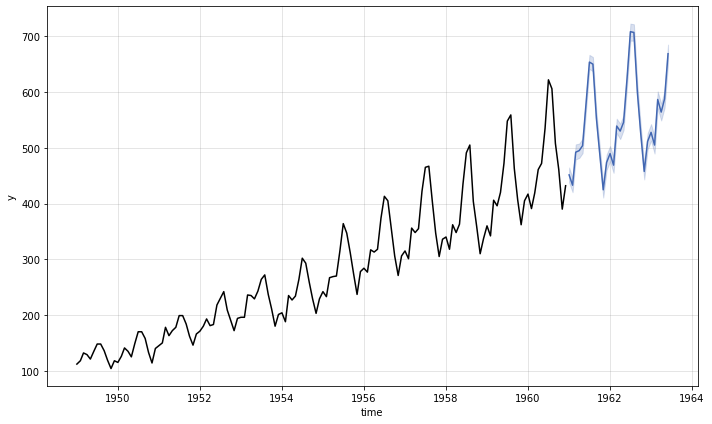

In [10]:
# declare parameters for Prophet model -  choose between additive or multiplicative
# multiplicative gives better results
params = ProphetParams(seasonality_mode='multiplicative') 

# fit a prophet model instance
model = ProphetModel(air_passengers_ts, params)
model.fit()

# forecast for next 30 months
fcst = model.predict(steps=30, freq="MS")

# visualize predictions
model.plot()